# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Loading required package: lme4
Loading required package: Matrix
Loading required package: Rcpp


Loading required package: lmerTest

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)
proj

{'comments': '',
 'envs': ['env1',
  'env2',
  'env3',
  'env4',
  'env5',
  'env6',
  'env7',
  'env8',
  'env9',
  'env10',
  'env11',
  'env12'],
 'goals': {'env1': {'animal': 'zebra',
   'face': 'George_Clooney',
   'food': 'lettuce'},
  'env10': {'animal': 'duck', 'face': 'Katy_Perry', 'food': 'grape'},
  'env11': {'animal': 'elephant', 'face': 'Johnny_Depp', 'food': 'carrot'},
  'env12': {'animal': 'panda', 'face': 'Zooey_Dechanel', 'food': 'apple'},
  'env2': {'animal': 'kitten', 'face': 'Mark_Zuckerberg', 'food': 'cucumber'},
  'env3': {'animal': 'brown_bear',
   'face': 'Emma_Watson',
   'tool': 'screwdriver'},
  'env4': {'animal': 'alligator', 'face': 'Natalie_Portman', 'tool': 'saw'},
  'env5': {'animal': 'flamingo',
   'face': 'Benedict_Cumberbatch',
   'tool': 'hammer'},
  'env6': {'animal': 'cow', 'face': 'Taylor_Swift', 'tool': 'tape_measure'},
  'env7': {'animal': 'giraffe', 'face': 'Jim_Parsons', 'tool': 'drill'},
  'env8': {'animal': 'puppy', 'face': 'Beyonce', 'food'

### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN


## Read in data files

In [5]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False

test_types = ['day3_test1', 'day3_test2']
test_trials = ['test1', 'test2']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for env in proj['envs']:
            for test_type, test_trial in zip(test_types, test_trials):
    #             print env
                # add test file
                test_file = op.join(dirs['datadir'], 'nav', test_type, env, 
                                    subid, 'session_0', 'log.txt')
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)
                d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d2['subid'] = subid
                d2['env'] = env
                d2['test_trial'] = test_trial

                # force time to be integer, diff from end to beginning
                d2.time = d2.time.astype(int)
                d2.time = d2.time - d2.time.min()

                df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)


1
2
3
4


## Look at data

In [6]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,env,test_trial
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,env1,test1
1,219,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,env1,test1
2,219,0,VR_INIT,,,None,None,None,None,1,env1,test1
3,219,0,VR_CREATED,,,None,None,None,None,1,env1,test1
4,2036,0,CONF_LOAD,./config.py,None,,,None,None,1,env1,test1


### Look at 2D position in space

In [7]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,env,test_trial
0,6736,1,terrain,"LPoint3f(0, 0, 0)",1,env1,test1
1,6736,1,zebra,"LPoint3f(4, 34, 0.5)",1,env1,test1
2,6736,1,lettuce,"LPoint3f(26, 52, 0.5)",1,env1,test1
3,6736,1,George_Clooney,"LPoint3f(20, 22, 0.5)",1,env1,test1
4,6736,1,PandaEPL_avatar,"LPoint3f(46, 2, 0.8)",1,env1,test1


In [8]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,env,test_trial,x,y,z
0,6736,terrain,1,env1,test1,0,0,0.0
1,6736,zebra,1,env1,test1,4,34,0.5
2,6736,lettuce,1,env1,test1,26,52,0.5
3,6736,George_Clooney,1,env1,test1,20,22,0.5
4,6736,PandaEPL_avatar,1,env1,test1,46,2,0.8


(<matplotlib.figure.Figure at 0x10cfc6990>,
 <matplotlib.axes.AxesSubplot at 0x120027310>)

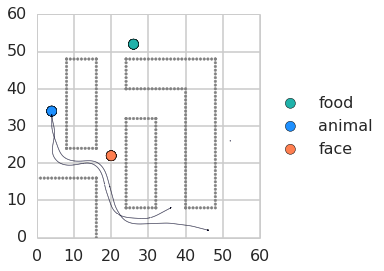

In [9]:
plot_paths(env='env1', subj='1', dp=dp, proj=proj)

(<matplotlib.figure.Figure at 0x1206b9d50>,
 <matplotlib.axes.AxesSubplot at 0x12628c3d0>)

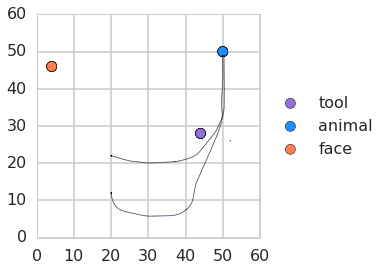

In [10]:
plot_paths(env='env3', subj='1', dp=dp, proj=proj)

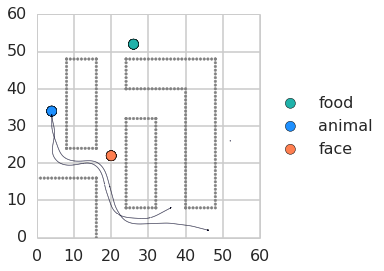

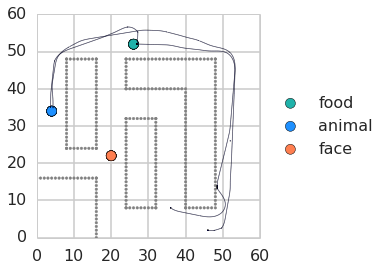

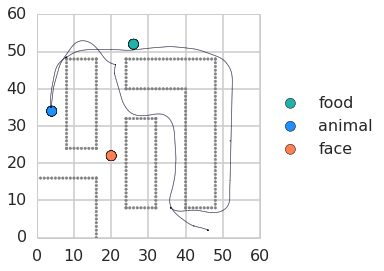

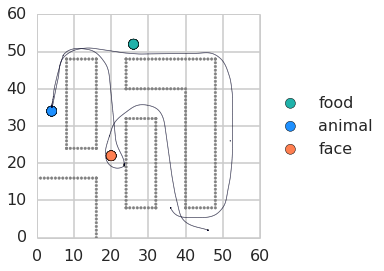

In [11]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env1', sub, dp, proj)

### Data for 1 subject, 1 environment

In [63]:
dsub = dp.query('env == "env3" & subid=="1" & c3=="PandaEPL_avatar"')
dsub.head()

,time,c3,subid,env,x,y,z
3502,4148,PandaEPL_avatar,1,env3,20,22,0.8
3510,4148,PandaEPL_avatar,1,env3,20,22,0.8
3512,4198,PandaEPL_avatar,1,env3,20,22,0.8
3522,4558,PandaEPL_avatar,1,env3,20,22,0.8
3524,5008,PandaEPL_avatar,1,env3,20,22,0.8


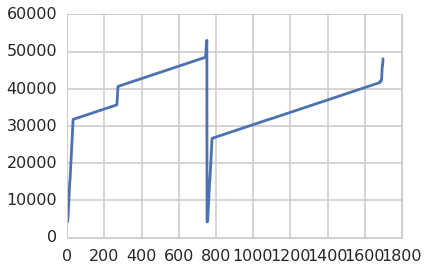

In [64]:
plt.plot(dsub.time)

In [14]:
dsub.time.max()

53018

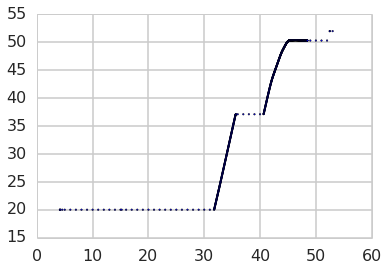

In [15]:
plt.scatter(dsub.time/1000, dsub.x.astype(float), 
            s=10, marker='.')

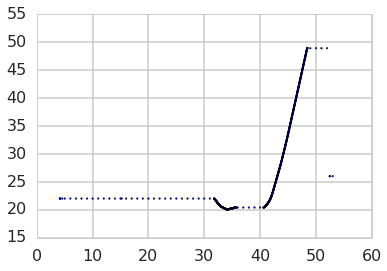

In [16]:
plt.scatter(dsub.time/1000, dsub.y.astype(float), 
            s=10, marker='.')

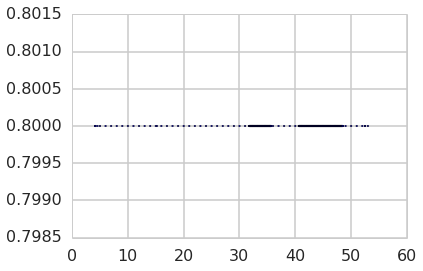

In [17]:
plt.scatter(dsub.time/1000, dsub.z.astype(float), 
            s=10, marker='.')

## Heading Direction

In [18]:
dh = df[(df.command == 'VROBJECT_HEADING') & (df.c3 == 'PandaEPL_avatar')].reset_index()
dh = dh.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dh.head()

,time,c2,c3,c4,subid,env
0,6736,1,PandaEPL_avatar,180.0,1,env1
1,8068,21,PandaEPL_avatar,225.0,1,env1
2,9338,11,PandaEPL_avatar,270.0,1,env1
3,10598,21,PandaEPL_avatar,315.0,1,env1
4,11858,11,PandaEPL_avatar,360.0,1,env1


### Look at data just for 1 sub in 1 env

In [19]:
dsub = dh.query('env == "env3" & subid=="1"')
dsub.head()

,time,c2,c3,c4,subid,env
2438,4148,1,PandaEPL_avatar,0.0,1,env3
2439,5478,11,PandaEPL_avatar,45.0,1,env3
2440,6738,21,PandaEPL_avatar,90.0,1,env3
2441,8008,11,PandaEPL_avatar,135.0,1,env3
2442,9278,11,PandaEPL_avatar,180.0,1,env3


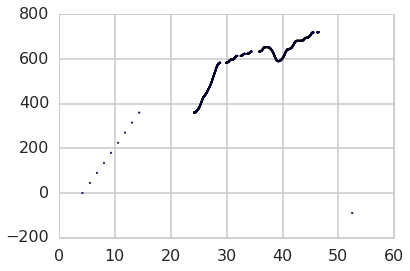

In [20]:
plt.scatter(dsub.time/1000, dsub.c4.astype(float), 
            s=10, marker='.')

## Text Events

In [21]:
dt = df[(df.command.isin(['ASSIGNED'])) 
        | df.command.isin(['ARRIVED'])].reset_index()
dt.ix[dt.command == 'ARRIVED', 'c3'] = 'between_trials'
dt = dt.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dt = dt.rename(columns={'c3': 'instructions'})
dt.head()

,time,instructions,subid,env
0,17778,zebra,1,env1
1,51348,between_trials,1,env1
2,16474,Mark_Zuckerberg,1,env2
3,42284,between_trials,1,env2
4,15198,brown_bear,1,env3


In [22]:
dt['total_time'] = (dt.time - dt.time.shift(1)).shift(-1)
dt.head()

,time,instructions,subid,env,total_time
0,17778,zebra,1,env1,33570
1,51348,between_trials,1,env1,-34874
2,16474,Mark_Zuckerberg,1,env2,25810
3,42284,between_trials,1,env2,-27086
4,15198,brown_bear,1,env3,33310


### Average time to navigate to goal

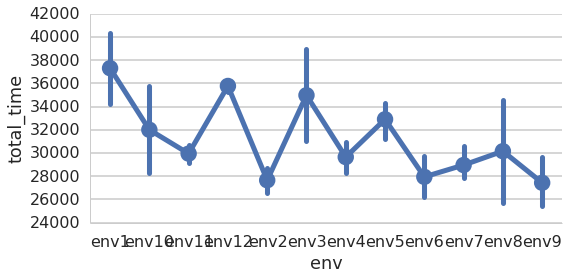

In [23]:
means = dt[dt.instructions != 'between_trials'].merge(subj_info).groupby(['subid', 'env']).mean().reset_index()
sns.factorplot(x='env', y='total_time', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means)

## Input Events

In [24]:
di = df[(df.command == 'INPUT_EVENT')].reset_index()
di = di.drop(['c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
di = di.query('(c3 != "dismiss") & (c3 != "exit")')
di.head()

,time,c2,c3,subid,env
0,27048,0,turnLeft,1,env1
1,27068,0,turnLeft,1,env1
2,27078,0,turnLeft,1,env1
3,27098,0,turnLeft,1,env1
4,27118,0,turnLeft,1,env1


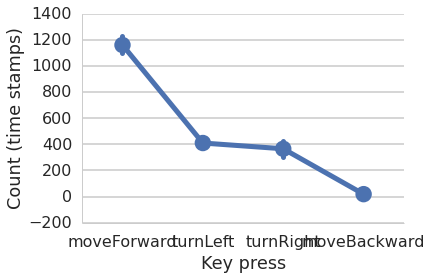

In [25]:
counts = di.merge(subj_info).groupby(['subid', 'env', 'c3']).count().reset_index()

sns.factorplot(x='c3', y='time', aspect=1.5,
               units='subid', ci=68, data=counts)
plt.ylabel('Count (time stamps)')
plt.xlabel('Key press')

## Merge dataframes

In [26]:
dpt = dp.merge(dt, on=['subid', 'env', 'time'], how='left')
dpt.ix[0,'instructions'] = 'intro'
dpt = dpt.fillna(method='ffill')
dpt.head()

,time,c3,subid,env,x,y,z,instructions,total_time
0,6736,terrain,1,env1,0,0,0.0,intro,NaN
1,6736,zebra,1,env1,4,34,0.5,intro,NaN
2,6736,lettuce,1,env1,26,52,0.5,intro,NaN
3,6736,George_Clooney,1,env1,20,22,0.5,intro,NaN
4,6736,PandaEPL_avatar,1,env1,46,2,0.8,intro,NaN


In [55]:
dpt.query('env == "env1" & c3 == "lettuce"')

,time,c3,subid,env,x,y,z,instructions,total_time
2,6736,lettuce,1,env1,26,52,0.5,intro,NaN
14661,6886,lettuce,2,env1,26,52,0.5,between_trials,-36026
31745,7272,lettuce,3,env1,26,52,0.5,between_trials,-37724
48210,6716,lettuce,4,env1,26,52,0.5,between_trials,-36998


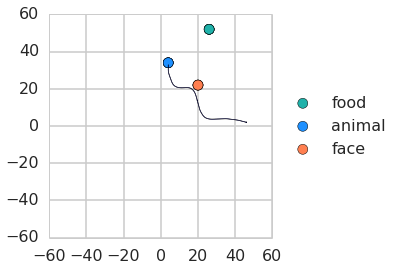

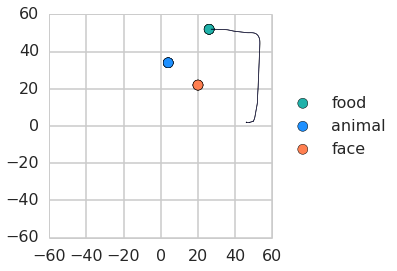

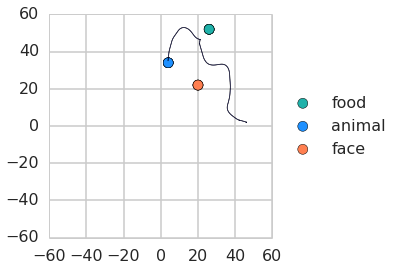

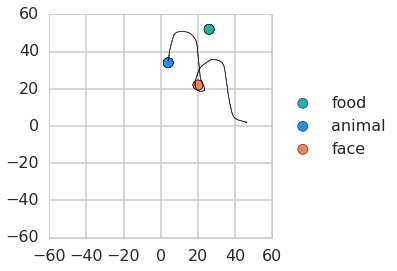

In [32]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_path('env1', sub, 'zebra', dpt, proj, dp)

(<matplotlib.figure.Figure at 0x11d077a50>,
 <matplotlib.axes.AxesSubplot at 0x11d2048d0>)

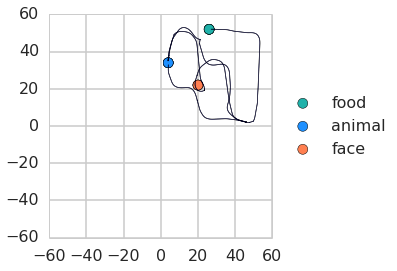

In [33]:
plot_path_group('env1', subj_info.subid, 'zebra', dpt, proj, dp)

(<matplotlib.figure.Figure at 0x11b6698d0>,
 <matplotlib.axes.AxesSubplot at 0x1198a3650>)

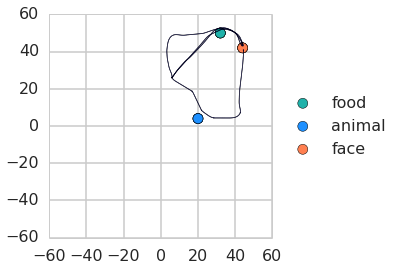

In [39]:
plot_path_group('env2', subj_info.subid, 'Mark_Zuckerberg', dpt, proj, dp)

In [40]:
dpt.query('env == "env3"').instructions.unique()

array(['between_trials', 'brown_bear'], dtype=object)

(<matplotlib.figure.Figure at 0x11d196310>,
 <matplotlib.axes.AxesSubplot at 0x119a15750>)

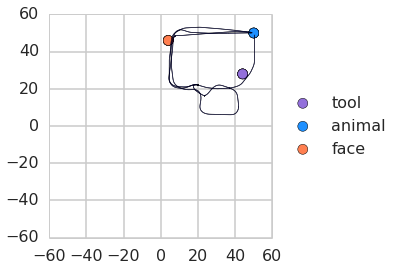

In [41]:
plot_path_group('env3', subj_info.subid, 'brown_bear', dpt, proj, dp)

In [42]:
dpt.query('env == "env4"').instructions.unique()

array(['between_trials', 'saw'], dtype=object)

(<matplotlib.figure.Figure at 0x119d63550>,
 <matplotlib.axes.AxesSubplot at 0x11d0c42d0>)

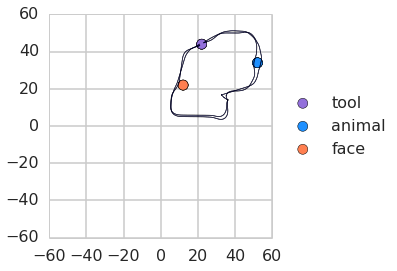

In [43]:
plot_path_group('env4', subj_info.subid, 'saw', dpt, proj, dp)

## Calculate Path Lengths

In [44]:
dpt.head()

,time,c3,subid,env,x,y,z,instructions,total_time
0,6736,terrain,1,env1,0,0,0.0,intro,NaN
1,6736,zebra,1,env1,4,34,0.5,intro,NaN
2,6736,lettuce,1,env1,26,52,0.5,intro,NaN
3,6736,George_Clooney,1,env1,20,22,0.5,intro,NaN
4,6736,PandaEPL_avatar,1,env1,46,2,0.8,intro,NaN


In [45]:
dplen = pd.DataFrame(columns=['subid', 'env', 'goal_type', 'path_len'])

for env in proj['envs']:
    goals = set(dpt[dpt.env == env].instructions)
    goals.discard('between_trials')
    goals.discard('intro')

    for subid in subj_info.subid:
#         print subid
        
        for goal in goals:
#             print goal

            goal_type = dict((v,k) for k,v in proj['goals'][env].items()).get(goal)
#             print goal_type
            data_sub = dpt[(dpt.subid == subid) & (dpt.env == env) & 
                           (dpt.instructions == goal) & 
                           (dpt.c3 == 'PandaEPL_avatar')]
            distance = sp.spatial.distance.euclidean(data_sub.x, data_sub.y)
            
            row = pd.Series({'subid': subid,
                             'env': env,
                             'goal_type': goal_type,
                             'path_len': distance})
            dplen = dplen.append(row, ignore_index=True)

In [46]:
dplen.head()

,subid,env,goal_type,path_len
0,1,env1,animal,683.199693
1,2,env1,animal,874.082704
2,3,env1,animal,1006.711420
3,4,env1,animal,994.722012
4,1,env2,face,521.736262


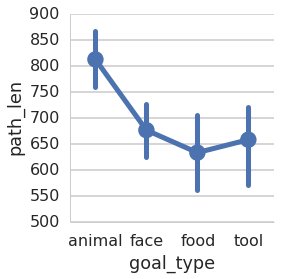

In [47]:
means = dplen.merge(subj_info).groupby(['subid', 'goal_type']).mean().reset_index()

sns.factorplot(x='goal_type', y='path_len', 
               units='subid', ci=68, dodge=.1,
               data=means)

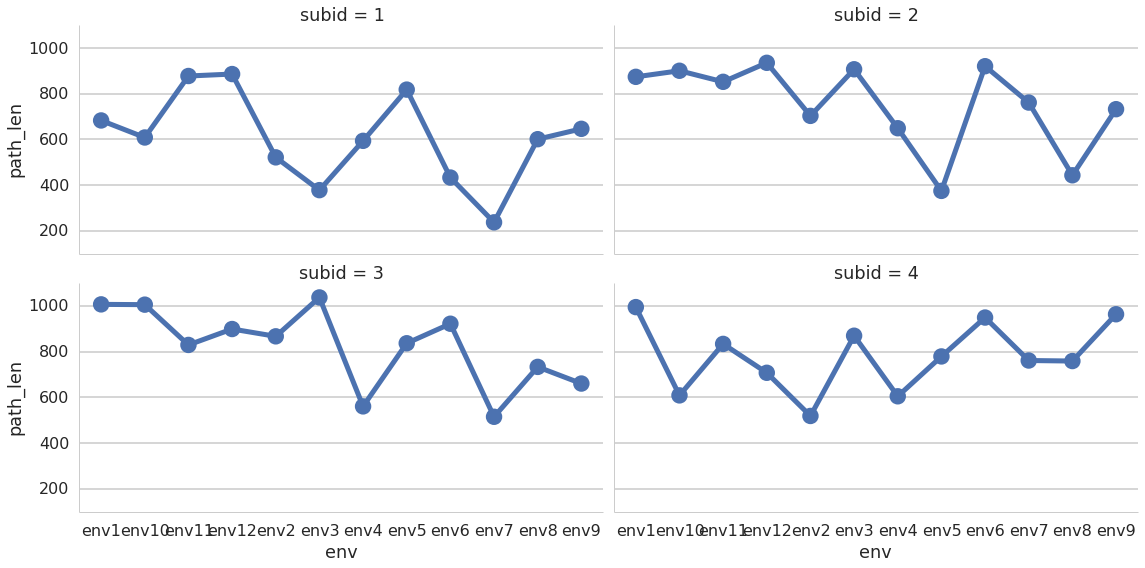

In [52]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               col='subid', col_wrap=2,
               dodge=.1,
               data=means)

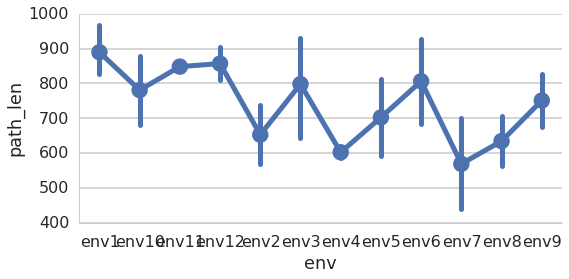

In [48]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means, )